<a href="https://colab.research.google.com/github/beginner003/developing-with-github/blob/master/CNN_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sketched Character Detection Using CNN

COMP2211 Programming Assignment 2, Spring 2024

# Overview (no task to complete)

## Problem Statement


Have you ever considered dancing with your sketched buddies? It is totally possible! In this programming assignment, we are going to take the very first step to extract the drawings from a paper, building our own CNN-based object detection model.


<img src="https://user-images.githubusercontent.com/6675724/219223438-2c93f9cb-d4b5-45e9-a433-149ed76affa6.gif" alt="teaser" width="600"/>


Image credits: https://github.com/facebookresearch/AnimatedDrawings


Object detection is a standard task in computer vision. The goal is to identify regions of interest from an input image. In our case, we are going to extract the bounding box for the character (2nd subfigure from left to right). A bounding box is the smallest rectangle region that wraps the object of interest. With the bounding box, it will be easy to segment the character from the image, and then facilitate the downstream animation generation tasks.

<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/segmentation-illustration.gif?raw=true" alt="segmentation" width="600"/>

## Dataset



We are using the *Amateur Drawings Dataset*. The original dataset comprises over 178K (~50Gb) images and associated annotations of amateur drawings. Due to the limit of Google Colab, the assiduous TAs have prepared a smaller sample.

<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/dataset.png?raw=true" alt="dataset_overview" width="600"/>

The filtered dataset has 2K (~500Mb) amateur drawing images. And the JSON file records the annotation list. Each entry has the `src` field about the relative path to the image, and the `bbox` field is defined by `[x, y, width, height]`, where `x` and `y` is the horizontal and vertical position of the top left corner.

```json
{
    "src": "images/1.png",
    "bbox": [
        32.0,
        56.888888888888886,
        303.36507936507934,
        428.69841269841265
    ]
}
```

Note that the coordination of a pixel-based image is different from the Cartesian coordinate system that you read in Mathemetics textbooks (see the figure below). The origin (0,0) is usually at the top-left corner of the image. The X-coordinate increases as you move to the right. The Y-coordinate increases as you move down.

<img src="https://cdn-learn.adafruit.com/assets/assets/000/001/264/medium800/lcds___displays_coordsys.png?1396770439" alt="image_coordination" width="400"/>

## Task Briefing

To implement the CNN model, we will utilize the `Tensorflow` and `Keras` packages. They are well-suited for individuals new to machine learning. For detailed information, please consult the official [documentation](https://www.tensorflow.org/api_docs/python/tf) or refer to an [example](https://www.tensorflow.org/hub/tutorials/object_detection).

We will also take advantage of a pre-trained model (a machine learning model that has been trained on a large dataset to perform specific tasks) -- the well-known ResNet. Using a pretrained model instead of training one from scratch is like having a seasoned chef prepare the base of your dish, rather than starting to cook without any prior kitchen experience. It has encapsulated rich knowledge from a general dataset of natural images in its parameters. We will use our unique dataset to combat its limited understanding of children's amateur drawings. To achieve this, we need to modify the model architecture to fit in our object detection task, while freezing its weights.

In this programming assignment, we will follow three procedures.

- Data loading
  - Load the dataset
  - Transform the data to fit in the model
     - **Task 1**: <u>normalize the bounding box feature</u> (graded for accuracy)
  - Split the data into training and testing dataset
     - **Task 2**: <u>split the dataset</u> (graded for accuracy)
- Model compilation & training
  - Build the object detection model based on ResNet
     - **Task 3**: <u>add the convolution layer</u> (graded for accuracy)
     - **Task 4**: <u>add the output layer</u> (graded for accuracy)
     - **Task 5**: <u>define the mean square loss function</u> (graded for accuracy)
     - **Task 6**: <u>define the GIoU loss function</u> (graded for accuracy)
  - Train the model
     - **Task 7**: <u>export trained parameters for plagiarism check</u>
- Performance evaluation
  - Examine model performance
     - **Task 8**: <u>compute loss and provide the poorest sample</u> (graded for accuracy)
  - Admire our powerful object detector 😎
     - **Task 9**: <u>use the model for new images</u> (graded for accuracy)
     - **Task 10**: <u>test out the model</u> (graded for performance)

After finishing all tasks, you should have four files for testing and grading: `proof.pkl`, `grading_prediction.pkl`, `self_testing_prediction.pkl`, and `pa2_task.py`.

## Tips

Please be aware that the files you upload to Colab won’t be available forever. Colab is a temporary environment with an idle timeout of 90 minutes and an absolute timeout of 12 hours. This means that the runtime will disconnect if it has remained idle for 90 minutes, or if it has been in use for 12 hours. On disconnection, you lose all your variables, states, installed packages, and files and will be connected to an entirely new and clean environment on reconnecting. Also, Colab has a disk space limitation of 108 GB, of which only 77 GB is available to the user.

# 🔥 Preliminaries

Let's set up the GPU environment to accelerate model training and suppress unnecessary system logs. First of all, you'll need to enable GPUs for the notebook <a href="https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d" target="_blank">(Learn how)</a>
- Navigate to `Edit` → `Notebook Settings`
- select `GPU` from the `Hardware Accelerator` drop-down

As there is limited free GPU quota in Colab, you may start training when you make sure everything is ready based on CPU.


**What does it mean to train models based on GPU and why?**

During training, the model iteratively adjusts its weights to minimize the difference between its predicted outputs and the true labels of the training examples. This process involves a lot of mathematical computations, especially matrix multiplications and convolutions. GPUs (Graphics Processing Units) are highly efficient at performing these types of computations, making them ideal for training CNN models. A GPU is a specialized electronic circuit designed to rapidly manipulate and alter memory to accelerate the creation of images in a frame buffer intended for output to a display device. While GPUs were originally designed for rendering graphics, they have evolved to become highly efficient at performing parallel computations, making them suitable for a wide range of applications beyond graphics processing.




In [ ]:
# Suppress warnings and logs
import warnings
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')


import tensorflow as tf

# Check whether a GPU environment is enabled
device_name = tf.test.gpu_device_name()
if len(device_name) > 0 and __name__ == '__main__':
    print("Found GPU at: {}".format(device_name))
elif __name__ == '__main__':
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))


Found GPU at: /device:GPU:0


# Data Loading (2 Tasks)



Here, we are going to download the dataset, transform the data format, and split it into the training and testing dataset.

**Task 1** — Normalize the bounding box feature

You should normalize the bbox into range [0, 1] according to the proportion to (img_width, img_height). That is, normalize the values according to the formula:

- x' = x / img_width
- y' = y / img_height
- width' = width / img_width
- height' = height / img_height

For example, suppose we have an image of size (100, 200), and a bbox with x = 30, y = 40, width = 50, height = 80, then we should normalize it to x = 30/100 = 0.3, y = 40/200 = 0.2, width = 50/100 = 0.5, height = 80/200 = 0.4.

After normalizing the values, append the list [x, y, width, height] to the bboxes list.

🔥 **In your Python submission, you should comment out (or remove) statements with `!` as its start or simply remove the following block. Or there will be syntax errors.** There are three places in this `ipynb` that you should be careful about.

In [ ]:
# # YOU HAVE TO COMMENT OUT THIS CELL WHEN HANDING IN THE CODE

# # Download the dataset from Amazon S3; It can take 1 min.
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/gt_bbox.json"
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/images.zip"

# !unzip -q images.zip

--2024-05-05 15:43:01--  https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/gt_bbox.json
Resolving comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)... 52.219.202.78, 3.5.143.145, 52.219.206.86, ...
Connecting to comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)|52.219.202.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 213750 (209K) [application/json]
Saving to: ‘gt_bbox.json.1’

gt_bbox.json.1      100%[===================>] 208.74K  1.30MB/s    in 0.2s    

2024-05-05 15:43:02 (1.30 MB/s) - ‘gt_bbox.json.1’ saved [213750/213750]

--2024-05-05 15:43:02--  https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/images.zip
Resolving comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)... 52.219.202.78, 3.5.143.145, 52.219.206.86, ...
Connecting to comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)

In [ ]:
import numpy as np
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


def preprocess_dataset(dataset, image_size=(224, 224)):
  """Preprocess the raw dataset
  dataset: the parsed JSON file as the dataset
  image_size: targeted image size for the model input

  return an array of the image paths, the transformed images and ground truth bboxes
  """
  images = []
  bboxes = []
  urls = []

  for item in dataset:
    url = item['src']
    urls.append(url)
    original_image = load_img(item['src'], target_size=None)
    original_width = original_image.width
    original_height = original_image.height
    image = original_image.resize(image_size)
    image = img_to_array(image)
    image = preprocess_input(image)
    images.append(image)

    bbox = item['bbox']
    x, y, width, height = bbox

    # Task 1: You should normalize the bbox into range [0, 1] according to the proportion to (width, height)
    ###### TO DO ######
    x=x/original_width
    y=y/original_height
    width=width/original_width
    height=height/original_height
    bboxes.append([x,y,width,height])
    ###################
  urls = np.array(urls, dtype=str)
  images = np.array(images, dtype=np.float32)
  bboxes = np.array(bboxes, dtype=np.float32)
  return urls, images, bboxes

**Task 2** — Split the dataset

You should split the dataset with `n` instances into two parts. One for training and one for testing. The training data and testing data should not overlap. Your function should work on an arbitrary input dataset of `np.ndarray`.

Based on the `test_split_ratio` ranged [0, 1], the target size of the testing dataset is `test_size = int(n * test_split_ratio)`. And the target size of the training dataset is `train_size = n - int(n * test_split_ratio)`.

In [ ]:
def split_dataset(urls, x, gt, test_split_ratio=0.2):
    """Split the dataset according to the test split ratio
    urls: the input image paths
    x: the input image data (np.ndarray) to be fed into model
    gt: the ground truth boundinng box (np.ndarray)
    test_split_ratio: the percentage of test dataset size in respect to the full dataset

    return the train_url, train_x, train_y, and test_url, test_x, and test_y
    """
    n = x.shape[0]
    test_size = int( n * test_split_ratio)

    # Task 2: You should split the data into train data and test data according to test_size
    ###### TO DO ######
    test_x =x[:test_size]
    train_x = x[test_size:]
    test_y = gt[:test_size]
    train_y = gt[test_size:]
    test_url=urls[:test_size]
    train_url=urls[test_size:]
    ###################
    return train_url, train_x, train_y, test_url, test_x, test_y

In [ ]:
import json

if __name__ == '__main__':
  N = 1000  # we only load N images for the assignment (max=2,000)
  IMAGE_SIZE = (224, 224) # ResNet standard image size
  DATASET_FILE = './gt_bbox.json'
  SPLIT_TEST_RATIO = 0.2

  with open(DATASET_FILE) as f:
      dataset = json.load(f)[:N]
  urls, images, bboxes = preprocess_dataset(dataset, image_size=IMAGE_SIZE)
  # print(urls.shape, images.shape, bboxes.shape)
  train_url, train_x, train_y, test_url, test_x, test_y = split_dataset(urls, images, bboxes, SPLIT_TEST_RATIO)
  # print(train_url.shape, train_x.shape, train_y.shape, test_url.shape, test_x.shape, test_y.shape)

(1000,) (1000, 224, 224, 3) (1000, 4)
(800,) (800, 224, 224, 3) (800, 4) (200,) (200, 224, 224, 3) (200, 4)


# Model Compilation & Training (5 tasks)

When using ResNet50 for classification, the model expects a fixed-size input image and outputs a 1D array where each entry corresponds to the probability that the image belongs to a particular class. However, for our task, which is bounding box prediction, the standard ResNet50 architecture needs to be adapted. Our goal is not to classify an entire image into a single category, but rather to predict the coordinates of a box that encloses an object within the image. These coordinates are usually represented by four values: (x, y, width, height).

Therefore, we will remove its original output layer and add custom layers for our task. Check the [Functional API](https://www.tensorflow.org/guide/keras/functional_api) in Keras.

Please finish the function create_model() to set up the model architecture. It begins by loading the ResNet50 model with pre-trained weights from ImageNet.

**Task 3** — Add a convolutional layer to the model.

Based on the output from previous layers, please set up a convolutional layer with 128 filters, kernel size = (3, 3), activated by 'relu', where the output vector should have the same size as the input.

**Task 4** — Add a fully connected layer to the model.

Based on the output from previous layers, please add a fully connected layer to output the prediction results.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Dropout

def create_model(input_shape=(224, 224, 3)):
  """Create a CNN model for predicting the bounding box for drawings in an image
  input_shape: the targeted image size

  return the model architecture
  """
  # load the pre-trained ResNet50 model without the top classification layer
  base_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
  # freeze the base model layers
  base_model.trainable = False
  # add custom layers on top for bounding box prediction
  model_x = base_model.output

  # Task 3: You should add a convolutional layer with 128 filters, kernel size = (3, 3), activated by 'relu', output the same size
  ###### TO DO ######
  model_x = Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding="same",input_shape=input_shape)(model_x)
  ###################

  model_x = GlobalAveragePooling2D()(model_x)  # use global average pooling to flatten the output
  model_x = Dropout(0.5)(model_x) # randomly drop out weights to avoid overfitting
  model_x = Dense(64, activation='relu', kernel_initializer='random_normal', name="check_layer_1")(model_x)  # add a fully connected layer
  model_x = Dense(32, activation='relu', kernel_initializer='random_normal', name="check_layer_2")(model_x)  # add a fully connected layer

  # Task 4: add a fully connected layer for predicting (x, y, w, h) for bounding box
  ###### TO DO ######
  model_x = Dense(4, activation='sigmoid', name="output")(model_x)
  ###################

  model = Model(inputs=base_model.input, outputs=model_x)
  return model

**Task 5** — Compute the sum of square error.

We will use the square error as our loss function. For the predicted bbox and the ground truth bbox, the loss is calculated by the square distance between their top left (tl) corner position and the bottom right (br) corner.

$$\text{SE} = ||\text{pred}_\text{tl} - \text{gt}_\text{tl}||^2 + ||\text{pred}_\text{br} - \text{gt}_\text{br}||^2  $$

To enable gradient descend in the training phase, the input variables are `tf.Tensor`. Therefore, to compute square values, please use `tf.square`.

In [ ]:
def se_func(x1_pred, y1_pred, w_pred, h_pred, x1_gt, y1_gt, w_gt, h_gt):
  """Compute the square error (SE) based on the tensor of (x, y, w, h) for the predicted bbox and ground truth

  return an (N, 1) tensor as the individual loss value
  """
  # Task 5: Compute the SE loss
  ###### TO DO ######
  se= tf.square(x1_pred-x1_gt)+tf.square(y1_pred-y1_gt)+tf.square(x1_pred+w_pred -x1_gt-w_gt)+tf.square(y1_pred+ h_pred -y1_gt- h_gt)

  return se
  ###################

**Task 6** — Compute the GIoU loss given the x, y, width, height of the predicted value and the ground truth.

In addition to MSE, the [generalized intersection over union (GIoU)](https://giou.stanford.edu/) loss function is also highly useful when training a bounding box prediction model. Its major steps are as follows.
1. Calculate the intersection ($\text{I}$) and the union ($\text{U}$) of the predicted and ground truth bounding boxes.
2. Find the coordinates of the enclosing box ($\text{C}$), i.e., the smallest box that would enclose both the predicted and ground truth bounding boxes.
3. The GIoU is then calculated by subtracting the normalized area of the difference between the enclosing box and the union from the IoU.
4. Get the GIoU loss, defined by 1 - GIoU.

<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/giou.png?raw=true" alt="bbox relationship" width="600"/>

To avoid divide-by-zero problem, you may add a small constant ($c=1\mathrm{e}-7$) to the denominator.

$$\text{IoU} = \frac{\text{Area of I}}{\text{Area of U} + c}$$

$$\text{GIoU} = \text{IoU} - \frac{\text{Area of C - Area of U}}{\text{Area of C + c}} $$

$$\text{GIoU Loss} = 1 - \text{GIoU} $$


To enable gradient descend in the training phase, the input variables are `tf.Tensor`. Therefore, to compute maximum or minimum, please use `tf.maximum` and `tf.minimum`.

In [ ]:
def giou_func(x1_pred, y1_pred, w_pred, h_pred, x1_gt, y1_gt, w_gt, h_gt):
  """Compute the giou loss based on the tensor of (x, y, w, h) for the predicted bbox and ground truth

  return an (N, 1) tensor as the loss value
  """
  # Task 6: Compute the GIOU loss given the prediction and the ground truth bbox data
  ###### TO DO ######
  x2_pred = x1_pred + w_pred
  y2_pred = y1_pred + h_pred
  x2_gt = x1_gt + w_gt
  y2_gt = y1_gt + h_gt

  #Intersection calculation
  x1_inner = tf.maximum(x1_pred,x1_gt)
  y1_inner = tf.maximum(y1_pred,y1_gt)
  x2_inner = tf.minimum(x2_pred,x2_gt)
  y2_inner = tf.minimum(y2_pred,y2_gt)
  intersection = (x2_inner-x1_inner)*(y2_inner-y1_inner)

  #Enclosure calculation
  x1_closure = tf.minimum(x1_pred,x1_gt)
  y1_closure = tf.minimum(y1_pred,y1_gt)
  x2_closure = tf.maximum(x2_pred,x2_gt)
  y2_closure = tf.maximum(y2_pred,y2_gt)
  closure = (x2_closure-x1_closure)*(y2_closure-y1_closure)

  #Union Calculation
  union = w_pred * h_pred + w_gt * h_gt - intersection



  iou = intersection / (union)
  glou = iou- (closure-union)/(closure)

  return 1-glou
  ###################


In [ ]:
@keras.saving.register_keras_serializable(name="loss")
def loss_func(pred, gt):
  """The loss function for model training.
  pred: an (N, 4) numpy array of predicted value for x, y, w, h
  gt: an (N, 4) numpy array of the ground truth value x, y, w, h

  return a scalar value of the mean batch loss
  """
  gt = tf.convert_to_tensor(gt, dtype=tf.float32)
  pred = tf.convert_to_tensor(pred, dtype=tf.float32)

  x1_gt, y1_gt, w_gt, h_gt = tf.split(gt, 4, axis=-1)
  x1_pred, y1_pred, w_pred, h_pred = tf.split(pred, 4, axis=-1)

  # you can also try using the mse error
  #loss = se_func(x1_pred, y1_pred, w_pred, h_pred, x1_gt, y1_gt, w_gt, h_gt)
  loss = giou_func(x1_pred, y1_pred, w_pred, h_pred, x1_gt, y1_gt, w_gt, h_gt)
  return tf.reduce_mean(loss)

In [ ]:
if __name__ == '__main__':
  model = create_model()
  model.compile(optimizer='adam', loss=loss_func)

You may run the following code to enable an advanced callback of TensorBoard. It is a visualization suite for models. You may inspect the real-time training logs through [scalar panel](https://www.tensorflow.org/tensorboard/scalars_and_keras) or gain a better understanding of the model architecture through the [model graph panel](https://www.tensorflow.org/tensorboard/graphs).

In [ ]:
from datetime import datetime
if __name__ == '__main__':
  # set up the tensorboard callback for reviewing real-time progress
  log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
  os.makedirs(log_dir, exist_ok=True)

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True)

In [ ]:
# load the tensorboard notebook extension
%load_ext tensorboard

In [ ]:
# remember to click the refresh button to load updated logs while training.
%tensorboard --logdir logs

In [ ]:
if __name__ == '__main__':
  # train the model, you may reduce the epoch number to test the functionability at first
  # as ResNet is a relatively large model, for 20 epochs, you may wait for 2 min using GPU, or 30 min using CPU
  N_EPOCH = 20
  model.fit(train_x, train_y, epochs=N_EPOCH, batch_size=64, callbacks=[tensorboard_callback])

Epoch 1/20
13/13 [==============================] - 7s 197ms/step - loss: 0.7336
Epoch 2/20
13/13 [==============================] - 3s 210ms/step - loss: 0.5235
Epoch 3/20
13/13 [==============================] - 3s 213ms/step - loss: 0.4875
Epoch 4/20
13/13 [==============================] - 3s 202ms/step - loss: 0.4673
Epoch 5/20
13/13 [==============================] - 3s 202ms/step - loss: 0.4644
Epoch 6/20
13/13 [==============================] - 3s 200ms/step - loss: 0.4422
Epoch 7/20
13/13 [==============================] - 3s 203ms/step - loss: 0.4375
Epoch 8/20
13/13 [==============================] - 3s 207ms/step - loss: 0.4202
Epoch 9/20
13/13 [==============================] - 3s 194ms/step - loss: 0.4259
Epoch 10/20
13/13 [==============================] - 3s 193ms/step - loss: 0.4129
Epoch 11/20
13/13 [==============================] - 2s 192ms/step - loss: 0.4080
Epoch 12/20
13/13 [==============================] - 2s 192ms/step - loss: 0.3991
Epoch 13/20
13/13 [======

**Task 7**: Export a proportion of the model parameters.

Run the following cell and download the model pameters to hand in for plagiarism checking.

In [ ]:
import pickle

def get_param_from_layer(model, layer_name):
    layer = model.get_layer(name=layer_name)
    weights = layer.get_weights()
    # Concatenate the weights into a single numpy array
    params = np.concatenate([w.flatten() for w in weights])
    return params

if __name__ == '__main__':
  param_1 = get_param_from_layer(model, 'check_layer_1').reshape((1, -1))
  param_2 = get_param_from_layer(model, 'check_layer_2').reshape((1, -1))
  proof = np.concatenate([param_1.T, param_2.T], axis=0)
  with open('proof.pkl', 'wb') as f:
    pickle.dump(proof, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# You can run this to save the model to your local machine to avoid re-training
if __name__ == '__main__':
  filename = 'model.keras'
  model.save(filename)
  model = tf.keras.models.load_model(filename, safe_mode=False, custom_objects={'loss_func': loss_func})

# Performance Evaluation (3 tasks)

We will examine the model performance based on the test dataset.

In [ ]:
if __name__ == '__main__':
  results = model.evaluate(test_x, test_y)
  print(f'The loss in the model: {results}')

7/7 [==============================] - 3s 93ms/step - loss: 0.4282
The loss in the model: 0.42824965715408325


In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_bounding_box(image_path, predicted_bbox=None, groundtruth_bbox=None):
  """Plot the original image, the predicted bounding box, and groundtruth (if any)
  image_path: the path to the image
  predicted_bbox: the predicted bounding box for drawings in the image
  groundtruth_bbox: the ground truth bounding box

  return void
  """
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  fig, ax = plt.subplots(1, figsize=(5, 5))
  ax.imshow(image)

  def draw_boxes(bbox, color, label):
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y-18, f'{label}', fontsize=12, verticalalignment='top', color=color)

  if predicted_bbox is not None:
      draw_boxes(predicted_bbox, 'red', 'Predicted')
  if groundtruth_bbox is not None:
      draw_boxes(groundtruth_bbox, 'green', 'Ground Truth')

  plt.axis('off')
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.show()

**Task 8** — Extract failure cases.

We are going to load a list of test data and associated ground truth.Please find out the one with the worst loss value.

For grading, please do not print anything else. It is guaranteed that the worst loss value only occurs once.



In [ ]:
def extract_failure_case(loss_function, pred, gt, k=5):
  """ Extract failure cases with the worst performance.
  model: the trained model
  loss_function: a loss function that calculates the scalar loss value for pairwise prediction (4,) and results (4,)
  pred: the predicted bounding box (scaled to the image size)
  gt: the ground truth bbox in the test dataset
  k: the number of top failures with the largest loss value

  return the indexes to the top k failure case
  """
  # Task 8: Extract failure cases
  ###### TO DO ######
  loss = np.zeros((len(pred),4))
  for i in range(len(pred)):
    loss[i]=loss_function(pred[i].flatten(),gt[i].flatten())
  # print("the loss shaoe is:", loss.shape)
  loss = loss.sum(axis=1)
  index = np.argsort(loss)[::-1][:k]
  # print(index)
  ###################
  return index

In [ ]:
def rescale_bbox(src, raw_pred, scaled_gt):
  original_image = load_img(src, target_size=None)
  original_width = original_image.width
  original_height = original_image.height
  def _rescale_bbox(bbox):
    x, y, w, h = bbox
    x = x * original_width
    y = y * original_height
    w = w * original_width
    h = h * original_height
    return np.array([x, y, w, h])
  return _rescale_bbox(raw_pred), _rescale_bbox(scaled_gt)

In [ ]:
from sklearn.metrics import mean_absolute_error
# You may refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

if __name__ == '__main__':
  test_pred = model.predict(test_x)
  n_failures = 20
  # print(test_pred.shape)
  worst_case_indexes = extract_failure_case(mean_absolute_error, test_pred, test_y, n_failures)
  # print(worst_case_indexes.shape)
  for k in range(n_failures):
    idx = worst_case_indexes[k]
    test_pred_instance, gt_instance = rescale_bbox(test_url[idx], test_pred[idx], test_y[idx])
    visualize_bounding_box(test_url[idx], test_pred_instance, gt_instance)

**Task 9** — Use the model based on an image input.
You are provided with the resized raw image data and a model. Please preprocess the image and use the model to predict the bounding box of the image.

In [ ]:
def predict_bounding_box(model, src):
  """leverage the model to identify drawings in an image
  model: a trained object detector model
  src: the source of the image file

  return [x, y, w , h] for the predicted bounding box in the original image
  """

  # Task 9: Using the input model to predict the bounding box [x, y, width, height] of a raw drawing image
  ###### TO DO ######
  original_image = load_img(src, target_size=None)
  original_width = original_image.width
  original_height = original_image.height
  image = original_image.resize((224, 224))
  image = img_to_array(image)

  image = np.expand_dims(image, axis=0)

  predictions = model.predict(image)

  x_pred = predictions[0][0] * original_width
  y_pred = predictions[0][1] * original_height
  w_pred = predictions[0][2] * original_width
  h_pred = predictions[0][3] * original_height

  bounding_box = [x_pred, y_pred, w_pred, h_pred]
  return bounding_box
  ###################


In [ ]:
from random import randint

def inspect(model, dataset, k=None):
  """Visually inspect one instance with its predicted and ground truth bbox
  model: the trained model
  dataset: the full dataset with image source and ground truth
  k: the index of the image under inspection

  return void
  """
  if k is None:
    k = randint(0, len(dataset)-1)
  src = dataset[k]['src']
  ground_truth = dataset[k]['bbox']
  pred = predict_bounding_box(model, src)
  visualize_bounding_box(src, pred, ground_truth)

1/1 [==============================] - 0s 36ms/step


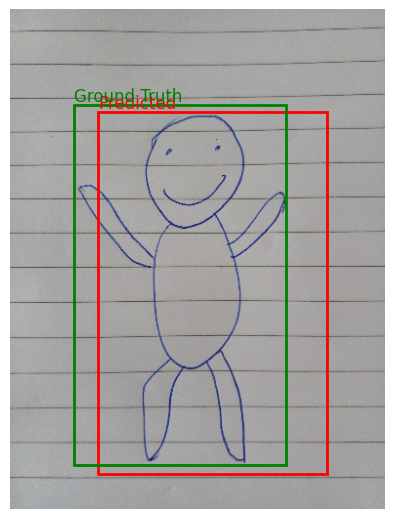

In [ ]:
if __name__ == '__main__':
  inspect(model, dataset)

1/1 [==============================] - 0s 52ms/step


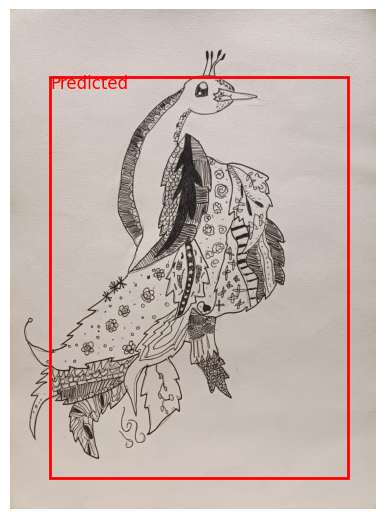

1/1 [==============================] - 0s 23ms/step


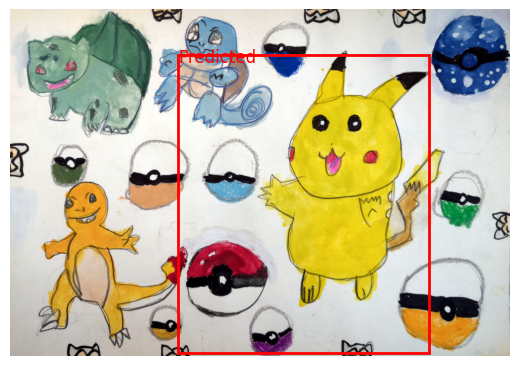

In [ ]:
# # YOU MUST COMMENT OUT THIS CELL WHEN HANDING IN THE CODE

# # Let us take a look at how your model performs on the drawings of Desmond's kids XD!
# !wget -O earnest.jpg "https://home.cse.ust.hk/~desmond/images/ernest/peacock.jpg" > /dev/null 2>&1
# !wget -O elvis.jpg "https://home.cse.ust.hk/~desmond/images/elvis/elvis-pokemon.jpg" > /dev/null 2>&1

# if __name__ == '__main__':
#   earnest_pred = predict_bounding_box(model, "earnest.jpg")
#   visualize_bounding_box("earnest.jpg", earnest_pred, None)
#   elvis_pred = predict_bounding_box(model, "elvis.jpg")
#   visualize_bounding_box("elvis.jpg", elvis_pred, None)

**Task 10** — Predict the bounding box on given data for grading

Run the following cell and download the generated data to hand in.
You can download the files from the [side panel](https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace) and submit it using the export `.py` file. You may need to refresh the panel before seeing the file.

<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/instruction.png?raw=true" alt="dataset_overview" width="500"/>




In [ ]:
# # YOU MUST COMMENT OUT THIS CELL WHEN HANDING IN THE CODE
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/grading_paths.pkl"
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/grading_images.zip"
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/testing_paths.pkl"
# !wget "https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/testing_images.zip"

# !unzip -q grading_images.zip
# !unzip -q testing_images.zip

--2024-05-05 16:27:55--  https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/grading_paths.pkl
Resolving comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)... 52.219.202.90, 52.219.202.62, 3.5.145.108, ...
Connecting to comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)|52.219.202.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5216 (5.1K) [binary/octet-stream]
Saving to: ‘grading_paths.pkl.1’

grading_paths.pkl.1 100%[===================>]   5.09K  --.-KB/s    in 0s      

2024-05-05 16:27:55 (300 MB/s) - ‘grading_paths.pkl.1’ saved [5216/5216]

--2024-05-05 16:27:55--  https://comp2211-pa2.s3.ap-northeast-2.amazonaws.com/grading_images.zip
Resolving comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northeast-2.amazonaws.com)... 52.219.202.90, 52.219.202.62, 3.5.145.108, ...
Connecting to comp2211-pa2.s3.ap-northeast-2.amazonaws.com (comp2211-pa2.s3.ap-northea

In [ ]:
import pickle
# Task 10: Download 'grading_pred.pkl' and `testing_pred.pkl`
if __name__ == '__main__':
  with open('grading_paths.pkl', 'rb') as f:
    paths = pickle.load(f)
  grading_pred = np.array([predict_bounding_box(model, path) for path in paths])
  with open('grading_pred.pkl', 'wb') as f:
    pickle.dump(grading_pred, f, pickle.HIGHEST_PROTOCOL)

  with open('testing_paths.pkl', 'rb') as f:
    paths = pickle.load(f)
  testing_pred = np.array([predict_bounding_box(model, path) for path in paths])
  with open('testing_pred.pkl', 'wb') as f:
    pickle.dump(testing_pred, f, pickle.HIGHEST_PROTOCOL)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Note: For grading on Zinc, please zip `grading_pred.pkl`, `proof.pkl`, and `pa2_task.py`.
# Note: For testing on Zinc, please zip `testing_pred.pkl`, `proof.pkl`, and `pa2_task.py`.
# When exporting this `.ipynb` to a `.py` file, you should comment out cells with statements starting with "!" or "%"

# Learn More (no task to complete)

So, what's next with the extracted drawings? You may dive into this SIGGRAPH [paper](https://arxiv.org/pdf/2303.12741.pdf) for more details. 🤫 It is not as difficult as you may expect. In general, there are three more steps, including segmentation, joint keypoint estimation, rig generation, and motion retargeting.

<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/pipeline.png?raw=true" alt="pipeline" width="960"/>


<img src="https://github.com/shellywhen/CNN-drawing-segmentation/blob/main/images/retarget.png?raw=true" alt="retarget" width="960"/>

You can also play with the [online demo](https://sketch.metademolab.com/) or install the [application](https://github.com/facebookresearch/AnimatedDrawings/tree/main) to create your own dancing buddy. Do you know what is even cooler? Try to create more magic with your own models🏂!